In [1]:
%load_ext autoreload

%autoreload 2

# Load Packages

In [2]:
from uacqr import uacqr
from helper import generate_data
from experiment import experiment

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

# Define Data Generating Process

In a conditional gaussian setting, set the conditional expectation and the conditional noise

In [4]:
def cond_exp(x):
    return np.sin(1/(x[:,0]**3))

def noise_sd_fn(x):
    return 1*x[:,0]**2

In [5]:
x_dist = partial(np.random.beta, a=1.2, b=0.8)

In [6]:
n=100
T=800 # number of test points
p=1
n0 = int(n/2) # number of training points

# Simulate Data

In [7]:
np.random.seed(1)
data = generate_data(n+T, p, cond_exp, noise_sd_fn, x_dist)

In [8]:
x = data[0]
y = data[1]

if len(x.shape)==1:
    x = x.reshape(-1,1)

x_train = x[:n0]
y_train = y[:n0]

x_calib = x[n0:n]
y_calib = y[n0:n]

x_test = x[n:]
y_test = y[n:]

Text(0.5, 1.0, 'Y versus X')

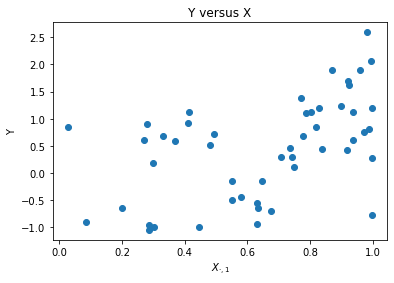

In [9]:
plt.scatter(x_train[:,0], y_train)
plt.xlabel('$X_{\cdot,1}$')
plt.ylabel('Y')
plt.title('Y versus X')

# Run LACQR

Define model hyperparameters

In [10]:
nn_params = {'dropout':0, 'epochs':1000, 'hidden_size':100, 'lr':1e-3, 'batch_norm':False, 
             'batch_size':2, 'normalize':True, 'weight_decay':0, 'epoch_model_tracking':True,
             "use_gpu":False}


Initialize uacqr class. We usually set $B$ to be one less than the number of epochs

In [11]:
%%time
uacqr_results = uacqr(nn_params,
                     model_type='neural_net',B=999, random_state=100, uacqrs_agg='std')

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 62.7 µs


Fit the base quantile regressors

In [12]:
uacqr_results.fit(x_train, y_train)

Conformalize / calibrate the quantile regressors

In [13]:
uacqr_results.calibrate(x_calib, y_calib)

# Evaluation

Evaluate the various conformal methods on test data

In [14]:
uacqr_results.evaluate(x_test, y_test)

{'interval_score_loss': {'UACQR-P': 3.057502205730704,
  'UACQR-S': 3.1053201248444964,
  'CQR': 3.2364745270058983,
  'CQR-r': 3.630058450876194,
  'Base': 3.9788405355148164},
 'test_coverage': {'UACQR-P': 0.95125,
  'UACQR-S': 0.94625,
  'CQR': 0.89,
  'CQR-r': 0.89875,
  'Base': 0.715},
 'average_length_test': {'UACQR-P': 2.7865229,
  'UACQR-S': 2.8401172,
  'CQR': 2.5759933,
  'CQR-r': 3.0045784,
  'Base': 1.7223779}}

# Plot Results (for simulated data)

All in one chart

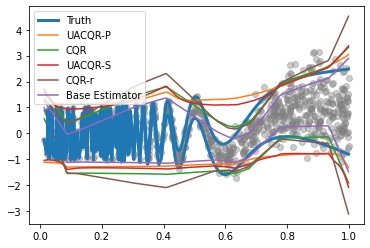

In [15]:
uacqr_results.plot(cond_exp, noise_sd_fn)

Graphic with simpler formatting

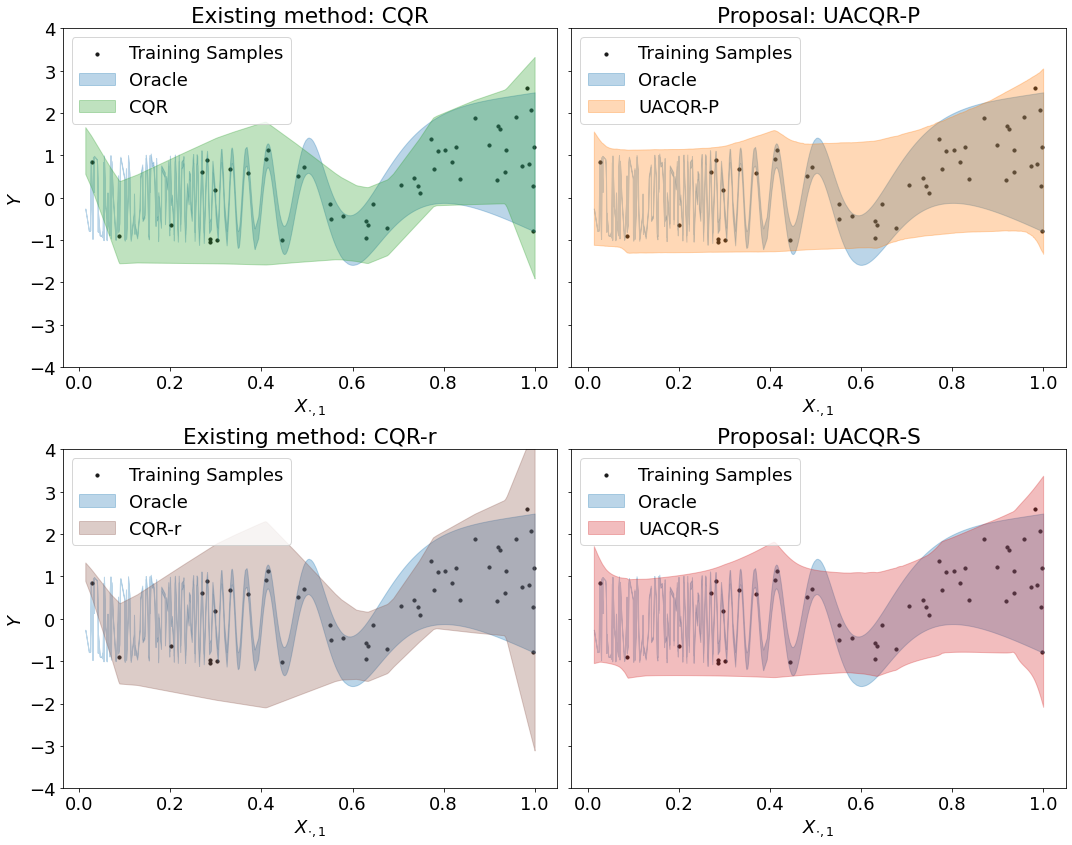

In [16]:
uacqr_results.plot_simple(cond_exp, noise_sd_fn,
                         xlabel='$X_{\cdot,1}$', expanded=True)
plt.tight_layout()